##### Objectives:
- Reach 73% accuracy score or above when predicting if a customer is happy or not based on the answers they give to questions asked.
- What is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have?
- Is there any question that we can remove in our next survey?

##### Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers<br>
X1 = my order was delivered on time<br>
X2 = contents of my order was as I expected<br>
X3 = I ordered everything I wanted to order<br>
X4 = I paid a good price for my order<br>
X5 = I am satisfied with my courier<br>
X6 = the app makes ordering easy for me<br>

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

##### Hypothesis:

Based on the description of each attribute,
- X3 seems least relevant to customer satisfaction.
- X1 would be most relevant to customer satisfaction as the company is in the logistics and delivery domain.
- X5 could also be important in predicting customer satisfaction for the same reason mentioned above.

1. Load libraries and initialize variables.

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from skfeature.function.similarity_based import fisher_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from scipy import stats
from scipy.stats.contingency import expected_freq
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

random_state = 1

In [9]:
survey_df = pd.read_csv("C:/Users/Admin/Documents/GitHub/NlupKgfEgSOdYRuv/data/ACME-HappinessSurvey2020.csv")
print(survey_df.head(), "\n")
print(survey_df.info(), "\n")
survey_df.describe()

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB
None 



,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


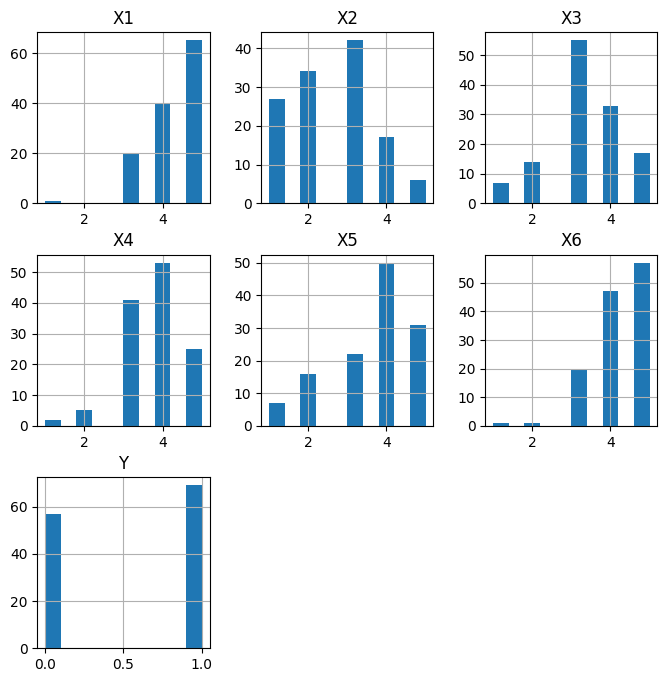

In [10]:
survey_df.iloc[:, [1,2,3,4,5,6,0]].hist(figsize=(8,8));



Y    0   1
X1        
1    1   0
3   12   8
4   24  16
5   20  45
Y          0         1
X1                    
1   0.394235 -0.357027
3   0.995392 -0.901445
4   1.407697 -1.274835
5  -1.716321  1.554331


Y    0   1
X2        
1   13  14
2   13  21
3   19  23
4   10   7
5    2   4
Y          0             1
X2                        
1   0.224818 -2.043353e-01
2  -0.607098  5.517877e-01
3   0.000000 -7.407920e-16
4   0.832810 -7.569352e-01
5  -0.433555  3.940552e-01


Y    0   1
X3        
1    4   3
2    7   7
3   29  26
4   11  22
5    6  11
Y          0         1
X3                    
1   0.468293 -0.425628
2   0.264906 -0.240772
3   0.825778 -0.750544
4  -1.016777  0.924141
5  -0.609582  0.554045


Y    0   1
X4        
1    0   2
2    4   1
3   20  21
4   23  30
5   10  15
Y          0         1
X4                    
1  -0.596962  0.544949
2   1.145743 -1.045916
3   0.315877 -0.288355
4  -0.222260  0.202895
5  -0.404520  0.369274


Y    0   1
X5        
1    5   2
2    9   7


,pearson_r,pearson_p,spearman_rho,spearman_p,kendall_tau,kendall_p
X1,0.280160,0.001486,0.291458,0.000929,0.277534,0.001120
X2,-0.024274,0.787313,-0.034304,0.702950,-0.031212,0.701322
X3,0.150838,0.091807,0.162199,0.069590,0.148970,0.069764
X4,0.064415,0.473623,0.081398,0.364889,0.075969,0.362793
X5,0.224522,0.011488,0.227306,0.010477,0.207467,0.011042
X6,0.167669,0.060568,0.174114,0.051191,0.165162,0.051576


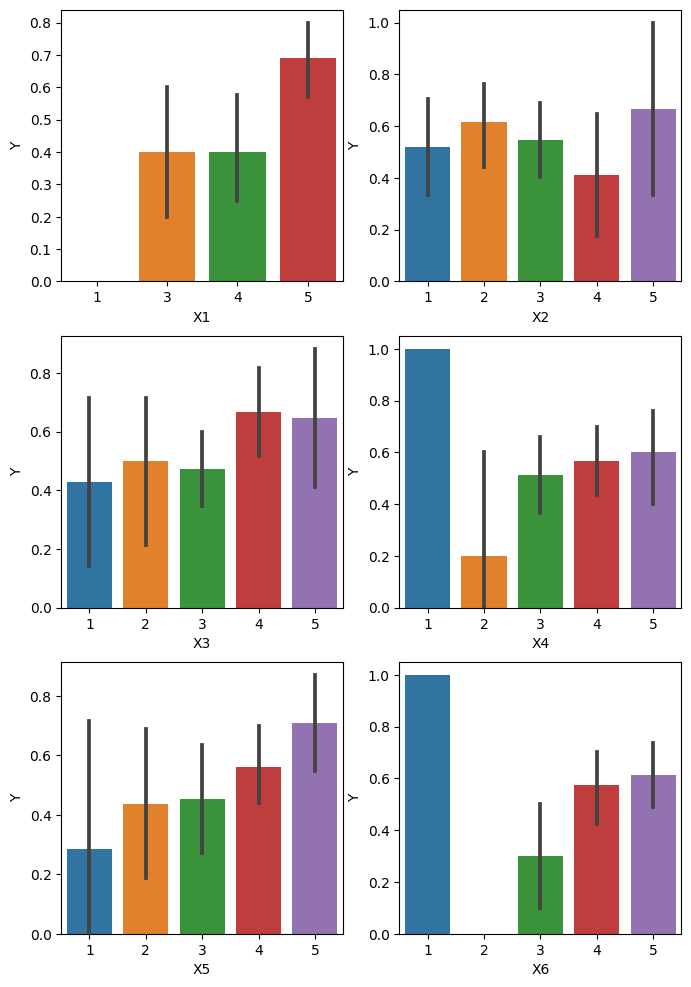

In [11]:
corr_df = pd.DataFrame(columns=["pearson_r", "pearson_p",
                                "spearman_rho", "spearman_p",
                                "kendall_tau", "kendall_p"])
fig, axes = plt.subplots(3, 2, figsize=(8,12))
for i, col in enumerate(survey_df.drop("Y", axis=1).columns):
    sns.barplot(survey_df, x=col, y="Y", ax=axes[i//2, i%2])
    x = survey_df[col]
    y = survey_df["Y"]
    print("\n")

    contingency_table = pd.crosstab(x, y)
    # expected_frequencies = expected_freq(contingency_table)
    print(contingency_table)
    # print(expected_frequencies)
    
    table = sm.stats.Table(contingency_table)
    print(table.resid_pearson)

    # chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    # print(chi2, p, dof, expected)
    
    # print(stats.chisquare(x))

    # for power in [1, 0, -1/2, -1]:
    #     print(stats.power_divergence(x, lambda_=power))

    r, r_p = stats.pearsonr(x, y)
    rho, rho_p = stats.spearmanr(x, y)
    tau, tau_p = stats.kendalltau(x, y)
    corr_dict = {
        "pearson_r": r,
        "pearson_p": r_p,
        "spearman_rho": rho,
        "spearman_p": rho_p,
        "kendall_tau": tau,
        "kendall_p": tau_p}
    corr_df = pd.concat([corr_df, pd.DataFrame(corr_dict, index=[col])], axis=0)

corr_df

- Based on the correlation coefficients, X2 and X4 would not be very helpful when predicting Y.
- Based on residuals from the expected frequencies, X1 and X5 would be most relevant in predicting Y; their correlation coefficients with Y are also higher.
- Correlation coefficients of X3 and X6 with Y are also high.

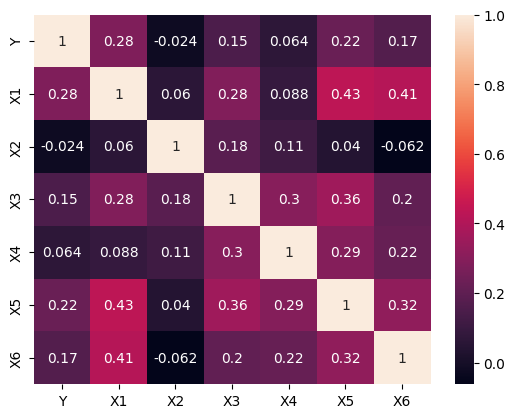

    information_gain  fisher_rank  feature_importance
X2          0.098703            5            0.181136
X6          0.011470            2            0.131518
X1          0.011153            1            0.159860
X4          0.000000            3            0.145704
X5          0.000000            4            0.185622
X3          0.000000            6            0.196160 

  information_gain fisher_rank feature_importance
0               X2          X1                 X3
1               X6          X6                 X5
2               X1          X4                 X2


In [185]:
def get_top_features(df, X, y, target_col="Y", top_n=3, show_heatmap=False, exclude_fisher_rank=False):
    # 1. Correlation with the target variable
    # plt.figure(figsize=(12,8))
    corr = df.corr()
    if show_heatmap:
        sns.heatmap(corr, annot=True)
        plt.show();
    
    scores_dicts = {}
    top_n_dicts = {}
    
    # corr_dict = {k: v for k, v in sorted(dict(corr[target_col].drop(target_col)).items(), key=lambda item: item[1], reverse=True)}
    # scores_dicts["correlation_coefficient"] = corr_dict
    # top_n_dicts["correlation_coefficient"] = list(corr_dict.keys())[:top_n]
    
    # 2. Information gain
    # Information gain calculates the reduction in entropy from the transformation of a dataset.
    # It can be used for feature selection by evaluating the Information gain of each variable 
    # in the context of the target variable.
    info_gain_scores = mutual_info_classif(X, y)
    info_gain = {col: info_gain_score for info_gain_score, col in zip(info_gain_scores, X.columns)}
    info_gain_sorted = {k: v for k, v in sorted(info_gain.items(), key=lambda item: item[1], reverse=True)}
    scores_dicts["information_gain"] = info_gain_sorted
    top_n_dicts["information_gain"] = list(info_gain_sorted.keys())[:top_n]
    
    # 3. Fisher's score
    # Fisher score is one of the most widely used supervised feature selection methods.
    # The .fisher_score method will return fisher scores where the higher the score, the better.
    fisher_scores = fisher_score.fisher_score(X.to_numpy(), y)
    fisher_ranks = {col: 6 - fisher_score for fisher_score, col in zip(fisher_scores, X.columns)}
    fisher_ranks_sorted = {k: v for k, v in sorted(fisher_ranks.items(), key=lambda item: item[1])}
    if not exclude_fisher_rank:
        scores_dicts["fisher_rank"] = fisher_ranks_sorted
        top_n_dicts["fisher_rank"] = list(fisher_ranks_sorted.keys())[:top_n]
    
    # 4. Use a simple random forest model for evaluating feature importances, etc.
    random_forest = RandomForestClassifier()
    random_forest.fit(X, y)
    feature_importances = random_forest.feature_importances_
    feature_importance = {col: feature_importance for feature_importance, col in zip(feature_importances, X.columns)}
    feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
    scores_dicts["feature_importance"] = feature_importance_sorted
    top_n_dicts["feature_importance"] = list(feature_importance_sorted.keys())[:top_n]
    
    if exclude_fisher_rank:
        scores_df = pd.DataFrame(scores_dicts).sort_values(
            ['information_gain', 'feature_importance'], ascending=[False, False])
    else:
        scores_df = pd.DataFrame(scores_dicts).sort_values(
            ['information_gain', 'fisher_rank', 'feature_importance'], ascending=[False, True, False])
    top_n_df = pd.DataFrame(top_n_dicts)
    
    return scores_df, top_n_df

X = survey_df.drop("Y", axis=1)
y = survey_df["Y"]
scores_df, top_n_df = get_top_features(survey_df, X, y, "Y", show_heatmap=True)
print(scores_df, "\n")
print(top_n_df)

Since information gain and feature importance scores are not fixed due to randomness, get the scores 100 times to see which features are generally more important regardless of randomness.

In [186]:
top_n_dfs = pd.DataFrame()
for i in range(100):
    _, top_n_df = get_top_features(survey_df, X, y, exclude_fisher_rank=True)
    top_n_dfs = pd.concat([top_n_dfs, top_n_df])

top_n_occurrence = defaultdict(int)
for i in range(len(top_n_dfs.columns)):
    col_dict = top_n_dfs.iloc[:,i].value_counts().to_dict()
    for k, v in col_dict.items():
        top_n_occurrence[k] += v

top_n_occurrence = dict(sorted(top_n_occurrence.items(), key=lambda item: item[1]))
top_n_occurrence

{'X4': 42, 'X6': 55, 'X1': 122, 'X2': 122, 'X3': 127, 'X5': 132}

Based on information gain and feature importance scores, X1 and X5 are still found to be the most importance features.
However, X2 was ranked in top 3 more often than X6, while the correlation coefficient of X6 was higher than X2. 

In [182]:
def get_mean_accuracy_scores(X, y, columns, n=100, test_size=0.05):
    # Choose a simple model as the base model since the data is not complex.
    base_model=RandomForestClassifier()
    accuracy_scores = []
    for i in range(n):
        _X = X[columns]
        X_train, X_test, y_train, y_test = \
            train_test_split(_X, y, test_size=test_size)
            
        base_model.fit(X_train, y_train)
        y_pred = base_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

    print(f"Mean accuracy score with columns {columns}: {round(np.mean(accuracy_scores), 2)}")

In [183]:
for col in X.columns:
    columns = list(X.columns)
    columns.remove(col)
    get_mean_accuracy_scores(X, y, columns)

Mean accuracy score with columns ['X2', 'X3', 'X4', 'X5', 'X6']: 0.53
Mean accuracy score with columns ['X1', 'X3', 'X4', 'X5', 'X6']: 0.58
Mean accuracy score with columns ['X1', 'X2', 'X4', 'X5', 'X6']: 0.56
Mean accuracy score with columns ['X1', 'X2', 'X3', 'X5', 'X6']: 0.58
Mean accuracy score with columns ['X1', 'X2', 'X3', 'X4', 'X6']: 0.66
Mean accuracy score with columns ['X1', 'X2', 'X3', 'X4', 'X5']: 0.6


In [184]:
for col in X.columns:
    get_mean_accuracy_scores(X, y, [col])

Mean accuracy score with columns ['X1']: 0.64
Mean accuracy score with columns ['X2']: 0.49
Mean accuracy score with columns ['X3']: 0.5
Mean accuracy score with columns ['X4']: 0.51
Mean accuracy score with columns ['X5']: 0.58
Mean accuracy score with columns ['X6']: 0.6


In [178]:
oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(survey_df.drop(["X2", "Y"], axis=1), survey_df["Y"])

In [179]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_balanced, y_balanced, test_size=0.05, random_state=random_state)

In [180]:
tuned_model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.4, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=60,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
tuned_model.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8571428571428571

In [124]:
def randomized_search(model, X_train, y_train, params,
                    scoring="accuracy", random_state=1, test_size=0.05, n_splits=2, n_iter=1000):
    sss = StratifiedShuffleSplit(random_state=random_state, test_size=test_size, n_splits=n_splits) # n_splits=10 by default
    best_searched = RandomizedSearchCV(estimator=model, param_distributions=params, cv=sss,
                                        scoring=scoring, random_state=random_state, n_iter=n_iter) # n_iter=10 by default
    best_searched.fit(X_train, y_train)
    return best_searched

In [160]:
params = {
    "n_estimators": [10, 50, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(1, 5, 1),
    "min_samples_split": np.arange(2, 10, 2),
    "max_features": ["sqrt", "log2", "auto", None],
    "min_impurity_decrease": np.arange(0.1, 1, 0.1),
    "bootstrap": [True, False],
    "oob_score": [True, False],
    "warm_start": [True, False],
    "class_weight": ["balanced", "balanced_subsample", None],
    "ccp_alpha": np.arange(0, 1, 0.1),
    "max_samples": np.arange(0.1, 1, 0.1)
}
base_model=RandomForestClassifier(random_state=random_state)
best_searched = randomized_search(base_model, X_train, y_train, params)
best_searched.best_estimator_, best_searched.best_score_, best_searched.best_params_

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py", line 351, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition f

(RandomForestClassifier(ccp_alpha=0.7000000000000001,
                        class_weight='balanced_subsample', criterion='entropy',
                        max_depth=2, max_samples=0.1,
                        min_impurity_decrease=0.30000000000000004,
                        min_samples_split=8, oob_score=True, random_state=1,
                        warm_start=True),
 0.6111111111111112,
 {'warm_start': True,
  'oob_score': True,
  'n_estimators': 100,
  'min_samples_split': 8,
  'min_impurity_decrease': 0.30000000000000004,
  'max_samples': 0.1,
  'max_features': 'auto',
  'max_depth': 2,
  'criterion': 'entropy',
  'class_weight': 'balanced_subsample',
  'ccp_alpha': 0.7000000000000001,
  'bootstrap': True})

In [187]:
rf_clf = RandomForestClassifier(ccp_alpha=0.7000000000000001,
                        class_weight='balanced_subsample', criterion='entropy',
                        max_depth=2, max_samples=0.1,
                        min_impurity_decrease=0.30000000000000004,
                        min_samples_split=8, oob_score=True, random_state=1,
                        warm_start=True)
rf_clf.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8571428571428571